<h1><center> <span style=\"color:#0ad0f7\">Sentiment Analysis Tweet Pemilu Indonesia 2019</span></center></h1>

🖋 Notebook Contents:

0. Initial Setup
1. Context
2. Problem Statement
3. Objective
4. Machine Learning Metrics
5. Exploratory Data Analysis (EDA)
6. Data Cleaning
7. Data Preparation
8. Model Development
9. Metric Evaluation
*****

## `Initial Setup`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import json

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nlp_id.lemmatizer import Lemmatizer
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

COLOR = "#85bb65"

#### **Context**:
Dataset yang akan digunakan adalah kumpulan data sentiment yang berasal dari pengguna twitter saat pelaksanaan PILPRES 2019 lalu. Terdiri dari 1815 data tweet yang memuat tiga kategori sentiment yaitu Positif, Netral dan Negatif.

#### **Problem Statement**:
Setiap tweet memuat teks yang mengandung salah satu sentiment yang ada, sehingga memungkinkan untuk melakukan pelatihan model untuk mempelajari teks dengan karakteristik sentiment terkait sehingga sangat berguna dalam pengembangan teknologi analisis sentiment secara otomatis.

#### **Objective**:
Membuat model machine learning klasifikasi untuk mengklasifikasikan tweet menjadi sentimen "Positive", "Negative", or "Neutral". Model maching learning yang akan digunakan adalah Random Forest, LSTM algorithm, dan model machine learning lainnya.

#### **Machine Learning Metrics**:
1. **Accuracy**
2. **Precision**
3. **Recall**

## `Exploratory Data Analysis (EDA)`

In [2]:
# load dataset
df_master = pd.read_csv('../data/tweet.csv', index_col=0)
df = df_master.copy()
df.head()

,sentimen,tweet
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1815 non-null   int64 
 1   sentimen    1815 non-null   object
 2   tweet       1815 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.7+ KB


In [6]:
print("POSITIVE: ",df[df['sentimen']=='positif']['tweet'].iloc[42]) # Positive
print("NEGATIVE: ",df[df['sentimen']=='negatif']['tweet'].iloc[42]) # Negative
print("NEUTRAL: ",df[df['sentimen']=='netral']['tweet'].iloc[42]) # Netral

POSITIVE:  Dulu sekadar ada pertumbuhan ekonomi tanpa pemerataan. Namun, asal kalian tau di zaman Pak @Jokowi bukan hanya pertumbuhan ekonomi tapi juga pemerataan pembangunan.  https://bit.ly/2UB5N4gÂ 
NEGATIVE:  Kalau yg difitnah ulama oposisi @DivHumas_Polri @CCICPolri diam walau mereka digaji uang negara, coba pro @jokowi langsung gaspol. Tolong pak @prabowo setelah terpilih buang semua petinggi polri era tito ke pedalaman, ganti yg baik  https://twitter.com/rmol_id/status/1117457492995231745Â â€¦
NEUTRAL:  Saat Jokowi masih menjadi pengusaha mebel di Solo. Mudzakir, guru ngaji Bpk @jokowi, pernah mendapat oleh-oleh dari "muridnya" sepulang dari Jerman. Yaitu korek api Zippo.  #PilihOrangBaik #PilihJelasIslamnya #PilihBajuPutih


In [7]:
df['sentimen'].value_counts()

positif    612
netral     607
negatif    596
Name: sentimen, dtype: int64

In [8]:
df['tweet_len'] = df['tweet'].apply(lambda x: len(x.split())) # split by space
df.head()

,sentimen,tweet,tweet_len
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,19
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",11
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",11
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",17
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,34


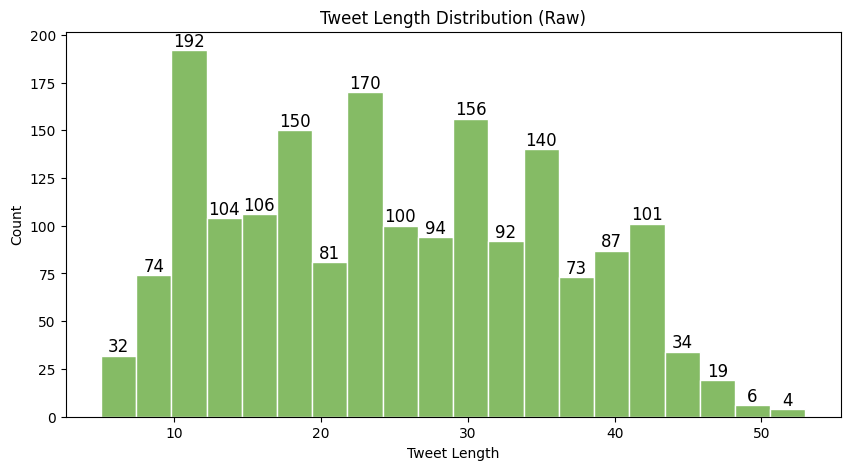

In [13]:
plt.figure(figsize=(10, 5))
values, bins, bars = plt.hist(df['tweet_len'], edgecolor='white',bins=20, color=COLOR)
plt.title('Tweet Length Distribution (Raw)')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.bar_label(bars, fontsize=12, color='black')
plt.show()

## `Data Cleaning`

1. URL
2. Email
3. Number
4. Mention
5. Hashtags
6. Non ASCII Character
7. Punctuation Handling

### `URL`

In [16]:
def extract_urls(text):
  """
  Function to extract URL from the tweet

  Parameters:
  text: tweet (string)

  """
  url_pattern = re.compile(r'https?://\S+|www\.\S+|pic\..+|\b\w+\.com\b')
  return re.findall(url_pattern, text)

In [20]:
df['urls'] = df['tweet'].apply(extract_urls)
display(df.head())
print("Jumlah data yang memiliki URL:", df['urls'].apply(len).sum())

,sentimen,tweet,tweet_len,urls
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,19,[https://twitter.com/mediaindonesia/status/111...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",11,[http://dlvr.it/R2pvZVÂ]
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",11,[pic.twitter.com/W2ythnxsTp]
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",17,[]
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,34,[]


Jumlah data yang memiliki URL: 649


In [21]:
def remove_urls(text):
    """
    Function to remove the URL

    Parameters:
    text: tweet (string)

    """
    url_pattern = re.compile(r'https?://\S+|www\.\S+|pic\..+|\b\w+\.com\b')
    return url_pattern.sub(' ', text)

In [23]:
# sample
print('URL Removal')
text_sample = df['tweet'].iloc[42]
print('Before: ',text_sample)
print('After: ',remove_urls(text_sample))

URL Removal
Before:  #GameofThrones Winter is coming Pidato Jokowi di IMF Bank Dunia  Ibaratkan Ekonomi Dunia seperti Game Of Thrones  Game of Throneâ€™, Presiden Jokowi: Penting, Kekuatan Bersama Untuk Kalahkan â€˜Evil Winterâ€™  http://setkab.go.id/seperti-game-of-throne-presiden-jokowi-penting-kekuatan-bersama-untuk-kalahkan-evil-winter/Â â€¦ â€¦ #2019TetapJokowi pic.twitter.com/B8bZPjbFFi
After:  #GameofThrones Winter is coming Pidato Jokowi di IMF Bank Dunia  Ibaratkan Ekonomi Dunia seperti Game Of Thrones  Game of Throneâ€™, Presiden Jokowi: Penting, Kekuatan Bersama Untuk Kalahkan â€˜Evil Winterâ€™    â€¦ â€¦ #2019TetapJokowi  


### `Emails`

In [24]:
def find_emails(text):
    """
    Function to find the emails

    Parameters:
    text: tweet (string)

    """

    pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\. [A-Z|a-z] {2,}\b'
    emails_found = re.findall(pattern, text)
    return emails_found

    # def remove_email(text):
    #     email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
    #     return email_pattern.sub(' ', text)

df['emails'] = df['tweet'].apply(find_emails)
display(df.head())

print("Total Emails:",df['emails'].apply(len).sum())

,sentimen,tweet,tweet_len,urls,emails
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,19,[https://twitter.com/mediaindonesia/status/111...,[]
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",11,[http://dlvr.it/R2pvZVÂ],[]
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",11,[pic.twitter.com/W2ythnxsTp],[]
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",17,[],[]
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,34,[],[]


Total Emails: 0


### `Numbers`

In [25]:
def find_numbers(text):
    """
    Function to find the Numbers

    Parameters:
    text: tweet (string)

    """
    return re.findall(r'\d+', text)

df['numbers'] = df['tweet'].apply(find_numbers)
print("Total Numbers:",df['numbers'].apply(len).sum())

Total Numbers: 2389


In [26]:
def remove_numbers(text):
    """
    Function to remove the Numbers

    Parameters:
    text: tweet (string)

    """
    number_pattern = re.compile(r'\d+')
    return number_pattern.sub(' ', text)

### `Mentions`

In [28]:
def find_mentions(text):
    """
    Function to find the mentions

    Parameters:
    text: tweet (string)

    """
    return re.findall(r'@[\w]*', text)

df['mentions'] = df['tweet'].apply(find_mentions)
display(df.head())
print("Total Mentions:",df['mentions'].apply(len).sum())

,sentimen,tweet,tweet_len,urls,emails,numbers,mentions
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,19,[https://twitter.com/mediaindonesia/status/111...,[],"[1117575436337160192, 21]","[@prabowo, @rockygerung]"
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",11,[http://dlvr.it/R2pvZVÂ],[],[2],[]
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",11,[pic.twitter.com/W2ythnxsTp],[],"[01, 2]",[]
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",17,[],[],"[18, 5]",[]
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,34,[],[],[],[]


Total Mentions: 774


In [29]:
def remove_mentions(text):
    """
    Function to remove the mentions

    Parameters:
    text: tweet (string)

    """
    mention_pattern = re.compile(r'@[\w]*')
    return mention_pattern.sub(' ', text)

### `Hashtags`

In [30]:
def find_hashtags(text):
    """
    Function to find the hashtags

    Parameters:
    text: tweet (string)

    """
    return re.findall(r'#[\w.]+', text)

df['hashtags'] = df['tweet'].apply(find_hashtags)
display(df.head())
print("Total Hashtags:",df['hashtags'].apply(len).sum())

,sentimen,tweet,tweet_len,urls,emails,numbers,mentions,hashtags
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,19,[https://twitter.com/mediaindonesia/status/111...,[],"[1117575436337160192, 21]","[@prabowo, @rockygerung]",[]
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",11,[http://dlvr.it/R2pvZVÂ],[],[2],[],[]
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",11,[pic.twitter.com/W2ythnxsTp],[],"[01, 2]",[],"[#01IndonesiaMaju, #JokowiLagi, #JokowiMenangT..."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",17,[],[],"[18, 5]",[],[]
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,34,[],[],[],[],[]


Total Hashtags: 966


In [32]:
def remove_hashtags(text):
  """
  Function to remove the hashtags

  Parameters:
  text: tweet (string)

  """
  return re.sub(r'#[\w.]+', '  ', text)

In [33]:
# sample to remove hashtags
text_sample = df['tweet'].iloc[42]
print('BEFORE: ',text_sample)
print('AFTER: ',remove_hashtags(text_sample))

BEFORE:  #GameofThrones Winter is coming Pidato Jokowi di IMF Bank Dunia  Ibaratkan Ekonomi Dunia seperti Game Of Thrones  Game of Throneâ€™, Presiden Jokowi: Penting, Kekuatan Bersama Untuk Kalahkan â€˜Evil Winterâ€™  http://setkab.go.id/seperti-game-of-throne-presiden-jokowi-penting-kekuatan-bersama-untuk-kalahkan-evil-winter/Â â€¦ â€¦ #2019TetapJokowi pic.twitter.com/B8bZPjbFFi
AFTER:     Winter is coming Pidato Jokowi di IMF Bank Dunia  Ibaratkan Ekonomi Dunia seperti Game Of Thrones  Game of Throneâ€™, Presiden Jokowi: Penting, Kekuatan Bersama Untuk Kalahkan â€˜Evil Winterâ€™  http://setkab.go.id/seperti-game-of-throne-presiden-jokowi-penting-kekuatan-bersama-untuk-kalahkan-evil-winter/Â â€¦ â€¦    pic.twitter.com/B8bZPjbFFi


### `Non ASCII characters`

In [34]:
def find_nonascii(text):
    """
    Function to remove the hashtags

    Parameters:
    text: tweet (string)

    """
    return re.findall(r'[^\x00-\x7f]', text)

df['nonascii'] = df['tweet'].apply(find_nonascii)
display(df.head())
print("Total Non ASCII:",df['nonascii'].apply(len).sum())

,sentimen,tweet,tweet_len,urls,emails,numbers,mentions,hashtags,nonascii
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,19,[https://twitter.com/mediaindonesia/status/111...,[],"[1117575436337160192, 21]","[@prabowo, @rockygerung]",[],"[ð, Ÿ, ‘, ‡, ð, Ÿ, ˜, œ, Â, , â, €, ¦]"
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",11,[http://dlvr.it/R2pvZVÂ],[],[2],[],[],"[Â, ]"
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",11,[pic.twitter.com/W2ythnxsTp],[],"[01, 2]",[],"[#01IndonesiaMaju, #JokowiLagi, #JokowiMenangT...",[]
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",17,[],[],"[18, 5]",[],[],[]
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,34,[],[],[],[],[],[]


Total Non ASCII: 4330


In [35]:
def remove_nonascii(text):
  """
  Function to remove the hashtags

  Parameters:
  text: tweet (string)

  """
  return re.sub(r'[^\x00-\x7f]', '  ', text)

In [36]:
sample_text = df['tweet'].iloc[42]
print('Non ASCII removal')
print('BEFORE: ',sample_text)
print('AFTER: ',remove_nonascii(sample_text))

Non ASCII removal
BEFORE:  #GameofThrones Winter is coming Pidato Jokowi di IMF Bank Dunia  Ibaratkan Ekonomi Dunia seperti Game Of Thrones  Game of Throneâ€™, Presiden Jokowi: Penting, Kekuatan Bersama Untuk Kalahkan â€˜Evil Winterâ€™  http://setkab.go.id/seperti-game-of-throne-presiden-jokowi-penting-kekuatan-bersama-untuk-kalahkan-evil-winter/Â â€¦ â€¦ #2019TetapJokowi pic.twitter.com/B8bZPjbFFi
AFTER:  #GameofThrones Winter is coming Pidato Jokowi di IMF Bank Dunia  Ibaratkan Ekonomi Dunia seperti Game Of Thrones  Game of Throne      , Presiden Jokowi: Penting, Kekuatan Bersama Untuk Kalahkan       Evil Winter        http://setkab.go.id/seperti-game-of-throne-presiden-jokowi-penting-kekuatan-bersama-untuk-kalahkan-evil-winter/                  #2019TetapJokowi pic.twitter.com/B8bZPjbFFi


### `Punctuation Handling`

Tanda baca digunakan dalam teks untuk memberikan struktur, memisahkan kalimat, menunjukkan kutipan, dan memberikan penekanan pada kata-kata tertentu. **Keberadaan tanda baca** seperti titik, koma, tanda tanya, dan tanda seru sering **tidak memberikan kontribusi signifikan** terhadap pemahaman teks dalam beberapa kasus analisis teks.

In [37]:
def find_punctuation(text):
    """
    Function to find the punctuation

    Parameters:
    text: tweet (string)

    """
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    return [char for char in text if char in punctuations]

# apply the function
df['punctuations'] = df['tweet'].apply(find_punctuation)
display(df.head())
print("Total Punctuations:",df['punctuations'].apply(len).sum())


,sentimen,tweet,tweet_len,urls,emails,numbers,mentions,hashtags,nonascii,punctuations
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,19,[https://twitter.com/mediaindonesia/status/111...,[],"[1117575436337160192, 21]","[@prabowo, @rockygerung]",[],"[ð, Ÿ, ‘, ‡, ð, Ÿ, ˜, œ, Â, , â, €, ¦]","[@, !, ,, @, ?, :, /, /, ., /, /, /, ?]"
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",11,[http://dlvr.it/R2pvZVÂ],[],[2],[],[],"[Â, ]","[,, ?, :, /, /, ., /]"
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",11,[pic.twitter.com/W2ythnxsTp],[],"[01, 2]",[],"[#01IndonesiaMaju, #JokowiLagi, #JokowiMenangT...",[],"[,, ., #, #, #, ., ., /]"
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",17,[],[],"[18, 5]",[],[],[],"[,, ,, ., ,, !]"
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,34,[],[],[],[],[],[],"[,, ,, ,, .]"


Total Punctuations: 16502


In [38]:
def remove_punctuation(text):
    """
    Function to remove the punctuation

    Parameters:
    text: tweet (string)

    """
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    return ''.join(' ' if char in punctuations else char for char in text)

# sample punctuation has been removed
sample_text = df['tweet'].iloc[42]
print('Punctuations removal')
print('BEFORE: ',sample_text)
print('AFTER: ',remove_punctuation(sample_text))

Punctuations removal
BEFORE:  #GameofThrones Winter is coming Pidato Jokowi di IMF Bank Dunia  Ibaratkan Ekonomi Dunia seperti Game Of Thrones  Game of Throneâ€™, Presiden Jokowi: Penting, Kekuatan Bersama Untuk Kalahkan â€˜Evil Winterâ€™  http://setkab.go.id/seperti-game-of-throne-presiden-jokowi-penting-kekuatan-bersama-untuk-kalahkan-evil-winter/Â â€¦ â€¦ #2019TetapJokowi pic.twitter.com/B8bZPjbFFi
AFTER:   GameofThrones Winter is coming Pidato Jokowi di IMF Bank Dunia  Ibaratkan Ekonomi Dunia seperti Game Of Thrones  Game of Throneâ€™  Presiden Jokowi  Penting  Kekuatan Bersama Untuk Kalahkan â€˜Evil Winterâ€™  http   setkab go id seperti game of throne presiden jokowi penting kekuatan bersama untuk kalahkan evil winter Â â€¦ â€¦  2019TetapJokowi pic twitter com B8bZPjbFFi


### `Case Folding (to lowercase)`

In [39]:
def to_lower_case(text):
    """
    Function to lower case the text

    Parameters:
    text: tweet (string)

    """
    return text.lower()

# sample to lower case the text
text_sample = df['tweet'].iloc[42]
print('BEFORE: ',text_sample)
print('AFTER: ',to_lower_case(text_sample))

BEFORE:  #GameofThrones Winter is coming Pidato Jokowi di IMF Bank Dunia  Ibaratkan Ekonomi Dunia seperti Game Of Thrones  Game of Throneâ€™, Presiden Jokowi: Penting, Kekuatan Bersama Untuk Kalahkan â€˜Evil Winterâ€™  http://setkab.go.id/seperti-game-of-throne-presiden-jokowi-penting-kekuatan-bersama-untuk-kalahkan-evil-winter/Â â€¦ â€¦ #2019TetapJokowi pic.twitter.com/B8bZPjbFFi
AFTER:  #gameofthrones winter is coming pidato jokowi di imf bank dunia  ibaratkan ekonomi dunia seperti game of thrones  game of throneâ€™, presiden jokowi: penting, kekuatan bersama untuk kalahkan â€˜evil winterâ€™  http://setkab.go.id/seperti-game-of-throne-presiden-jokowi-penting-kekuatan-bersama-untuk-kalahkan-evil-winter/â â€¦ â€¦ #2019tetapjokowi pic.twitter.com/b8bzpjbffi


### `Normalize Space`

In [40]:
def normalize_space(text):
  return re.sub(r"\s+", " ", text)  # Replace multiple spaces with a single space

### `Stopwords Handling`

In [41]:
slangs_url = 'https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt'
acronyms_url = 'https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/acronym.txt'
stopwods_url = 'https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_stop_words.txt'

In [45]:
# akronim
acronyms = pd.read_csv(acronyms_url,delimiter='\t',header=None)
acronyms.columns = ['raw']
acronyms[['acronyms','abbreviation']] = acronyms.raw.str.split(pat=' = ',expand=True)
acronyms_dict = pd.Series(acronyms.abbreviation.values,index=acronyms.acronyms).to_dict()

In [46]:
# slang word
slangs = pd.read_csv(slangs_url,delimiter='\t')
slangs_dict = json.loads(slangs.columns[0])

In [47]:
# remove slang @ because we already have puntuation handling for this case
del slangs_dict['@']

In [49]:
# slang dictionary manually
slangs_dict_manual = {"gak":"tidak","gaes":"teman","tsb":"tersebut","ngak":"tidak"}

In [50]:
# store the akronim and slang
slangs_acronyms_dict = {**acronyms_dict,**slangs_dict,**slangs_dict_manual}

In [51]:
def transform_slangs(text):
  words = text.split()
  text = [slangs_acronyms_dict[text] if text in list(slangs_acronyms_dict.keys()) else text for text in words]
  text = ' '.join(text)
  return text

In [52]:
# sample to transform the slang into the formal one
sample_text = 'gaes aku tidak suka baju yg putih'
print('BEFORE: ',sample_text)
print('AFTER: ',transform_slangs(sample_text))

BEFORE:  gaes aku tidak suka baju yg putih
AFTER:  teman aku tidak suka baju yang putih


In [55]:
# negation words
negation_words = {}

for _,k in enumerate(slangs_dict):
  if 'tidak' in slangs_dict[k]:
    negation_words[k] = slangs_dict[k]

negation_words = list(set(negation_words.values()))

In [57]:
stopwords_owen = pd.read_csv(stopwods_url)
stopwords_owen = stopwords_owen[stopwords_owen.columns[0]].tolist()

In [59]:
# stopword from nltk library
nltk.download('stopwords')
nltk.download('punkt')

stopwords_nltk = list(set(stopwords.words('indonesian')))
len(stopwords_nltk)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


757

In [60]:
# combine all of the stopword
stopwords_combine = list(set(stopwords_owen+stopwords_nltk))
len(set(stopwords_combine))

834

In [61]:
def remove_stopwords(text,drop_negation=False):
  """
  Function to remove stopwords

  Parameters:
  text: tweet (string)

  """
  words = text.split()
  if drop_negation==True:
    filtered_words = [word for word in words if word not in stopwords_combine]
  else:
    filtered_words = [word for word in words if (word not in stopwords_combine or word=='tidak')]
  return ' '.join(filtered_words)


In [62]:
# sample tweet
sample_text = 'aku tidak suka janji-janji palsu'
print('BEFORE: ',sample_text)
print('AFTER: ',remove_stopwords(sample_text))

BEFORE:  aku tidak suka janji-janji palsu
AFTER:  tidak suka janji-janji palsu


In [64]:
def remove_tiny_char(text):
  """
  Function to remove tiny char

  Parameters:
  text: tweet (string)

  """
  return re.sub(r'\b\w{1,2}\b', '', text)

In [65]:
# sample to remove tiny char
sample_text = 'Ak pengen lihat Indonesia jadi negara maju'
print('BEFORE: ',sample_text)
print('AFTER: ',remove_tiny_char(sample_text))

BEFORE:  Ak pengen lihat Indonesia jadi negara maju
AFTER:   pengen lihat Indonesia jadi negara maju


In [66]:
def cleaning_text(text):
  """
  function to clean the text

  """
  text = remove_urls(text)
  text = remove_numbers(text)
  text = remove_mentions(text)
  text = remove_nonascii(text)
  text = remove_hashtags(text)
  text = to_lower_case(text)
  text = remove_punctuation(text)
  text = transform_slangs(text)
  text = remove_tiny_char(text)
  text = normalize_space(text)
  text = remove_stopwords(text,drop_negation=False)
  return text

In [67]:
# Random Check Cleaning Text
import random
n = random.randint(0,len(df['tweet']))
text_sample = df['tweet'].iloc[n]
print(n)
print('BEFORE: ',text_sample)
print('AFTER: ',cleaning_text(text_sample))

1036
BEFORE:  Gaji sepeser tak diambil, hanya ambil utk balik modal dan bayar hutang prabowo 6.9 T saja ya. + keuntungam sekian T.  Wooooii lelembut, kami rakyat Indonesia tidak sebodoh pendukungmu yg 7 juta umat itu.
AFTER:  gaji sepeser tidak diambil ambil modal bayar hutang prabowo iya + keuntungam wooooii lelembut rakyat indonesia tidak sebodoh pendukungmu juta umat


In [68]:
# IMPORTANT
# this will be iterative
slangs_dict_manual = {"gak":"tidak","gaes":"teman","tsb":"tersebut","ngak":"tidak","bego":"bodoh","ln":"luar negeri","ci":"mba","smlm":"semalam","tps":"tempat pemungutan suara","ngutang":"berhutang", "bngun":"bangun","blm":"belum","menajdikan":"menjadikan"}
stopwords_manual = ['oh','oohhh','mba','tersebut','deh']

# UPDATE SLANGS AND STOPWORDS
slangs_acronyms_dict = {**slangs_acronyms_dict,**slangs_dict_manual}
stopwords_combine = list(set(stopwords_combine+stopwords_manual))

In [69]:
# apply the clean function to clean the tweet
df['tweet_clean'] = df['tweet'].apply(cleaning_text)

In [70]:
# clean tweet
df_clean = df[['tweet','tweet_clean','sentimen']]
df_clean.head()

,tweet,tweet_clean,sentimen
0,Kata @prabowo Indonesia tidak dihargai bangsa ...,indonesia tidak dihargai bangsa asing berita i...,negatif
1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...,netral
2,"Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia indonesiamaju,netral
3,"Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian games berdampak ekonomi...,positif
4,Negara kita ngutang buat bngun infrastruktur y...,negara berhutang bangun infrastruktur dipake m...,negatif


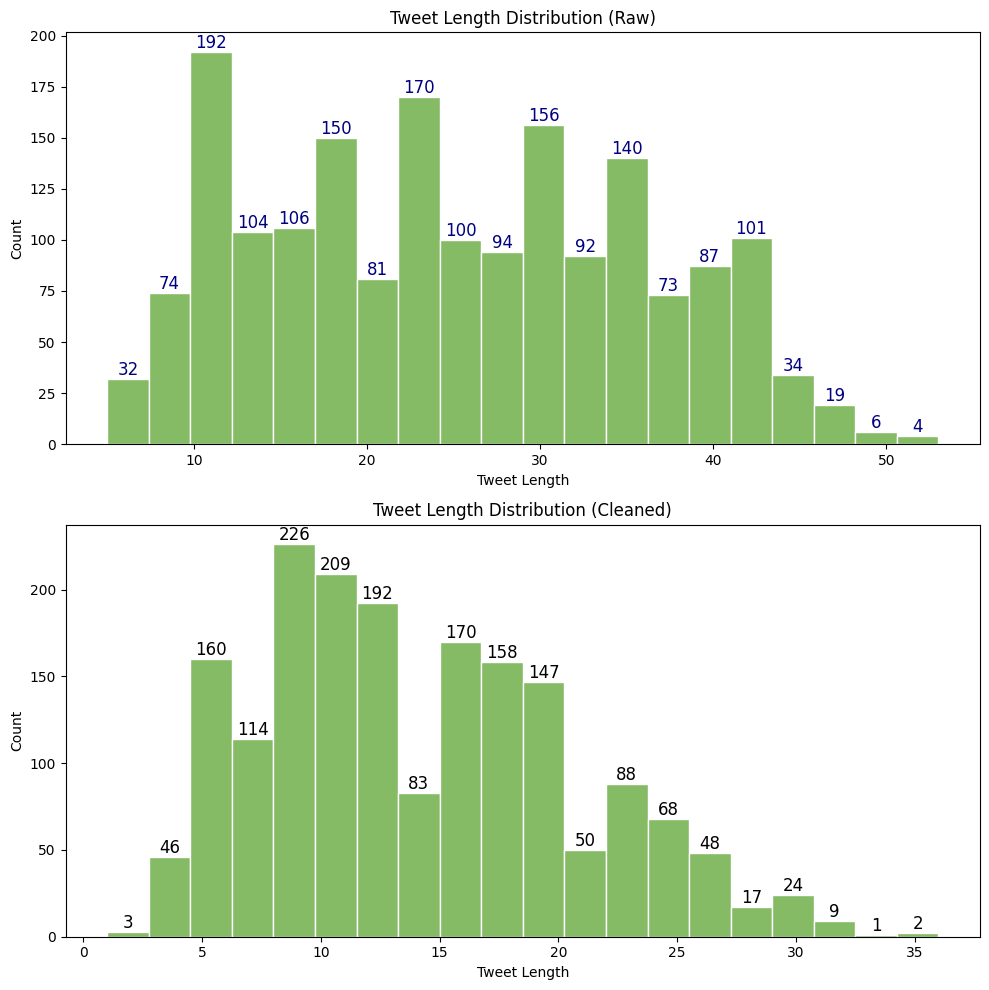

In [72]:
plt.figure(figsize=(10, 10))
len_tweet = df_clean['tweet'].apply(lambda x: len(x.split()))
len_tweet_clean = df_clean['tweet_clean'].apply(lambda x: len(x.split()))

# raw plot
plt.subplot(2, 1, 1)
values, bins, bars = plt.hist(len_tweet, edgecolor='white',bins=20, color=COLOR)
plt.title('Tweet Length Distribution (Raw)')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.bar_label(bars, fontsize=12, color='navy')

# clean plot
plt.subplot(2, 1, 2)
values, bins, bars = plt.hist(len_tweet_clean, edgecolor='white',bins=20, color=COLOR)
plt.title('Tweet Length Distribution (Cleaned)')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.bar_label(bars, fontsize=12, color='black')

plt.tight_layout()
plt.show()

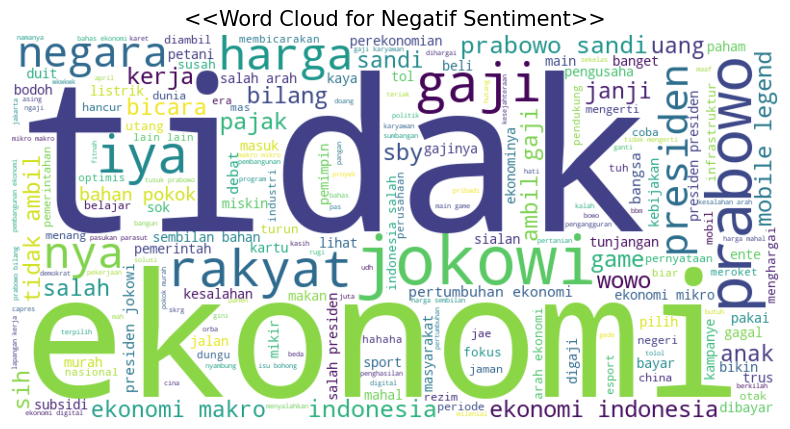

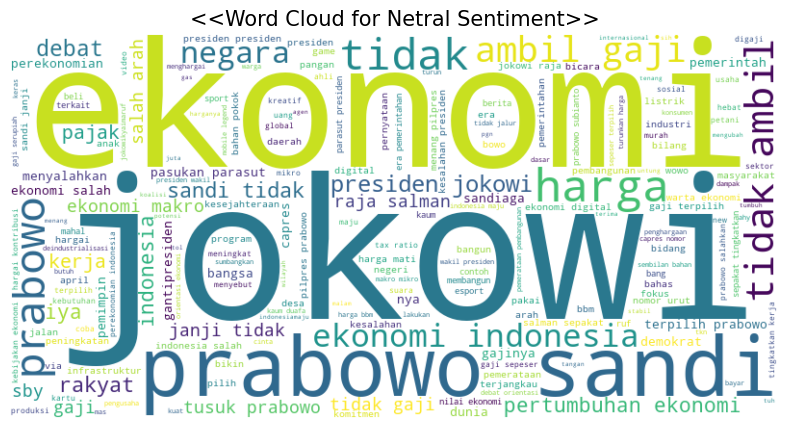

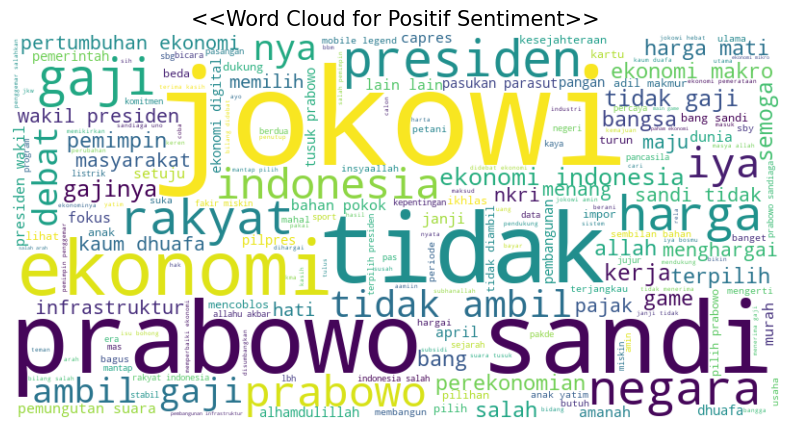

In [75]:
# Word Cloud

# Fungsi untuk membuat word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Buat word cloud untuk setiap kelas sentimen
sentiments = df_clean['sentimen'].unique()

for sentiment in sentiments:
    text = " ".join(tweet for tweet in df[df['sentimen'] == sentiment]['tweet_clean'])
    generate_wordcloud(text, f'<<Word Cloud for {sentiment.capitalize()} Sentiment>>')


## `Data Preparation`

1. Stemming
2. Lemmatization
3. Train, Test, Validation Split
4. Vectorization

### `Stemming`

In [77]:
# Inisialisasi stemmer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi untuk stemming menggunakan Sastrawi
def stemmer_sastrawi(text):
    return stemmer.stem(text)

In [78]:
# Random Check Stemmer
import random
n = random.randint(0,len(df['tweet']))
text_sample = df['tweet'].iloc[1464]
print(n)
print('BEFORE: ',text_sample)
print('AFTER: ',stemmer_sastrawi(cleaning_text(text_sample)))

769
BEFORE:  mungkin nanti kalo pak jokowi kepilih lagi, alangkah lebih baiknya menajdikan paslon 2 jadi menteri ekonomi. jadi indonesia makin maju.  tos dulu dong, gw dah cocok jd presiden blm?
AFTER:  jokowi pilih alangkah baik jadi paslon menteri ekonomi indonesia maju tos cocok presiden


### `Lemmatization`

In [82]:
def lemmatizer_nlpid(text):
  text = Lemmatizer().lemmatize(text)
  return text

In [83]:
# Random Check Lemmatizer
import random
n = random.randint(0,len(df['tweet']))
text_sample = df['tweet'].iloc[n]
print(n)
print('BEFORE: ',text_sample)
print('AFTER: ',lemmatizer_nlpid(cleaning_text(text_sample)))

961
BEFORE:  mmng lah luar biasa pendukung 02, presiden RI kl di dlm negeri di hina" , sdngkan orng luar negeri aja bnr" bs menghargai presiden jokowi
AFTER:  mmng dukung presiden negeri hina sdngkan orng negeri bnr harga presiden jokowi


In [84]:
def data_prep(text_clean):
  text_prep = stemmer_sastrawi(text_clean)
  text_prep = lemmatizer_nlpid(text_clean)
  return text_prep

In [85]:
df_clean['tweet_clean_prep'] = df_clean['tweet_clean'].apply(data_prep) # this line takes ~27 mins
df_clean.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9728\3438093336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['tweet_clean_prep'] = df_clean['tweet_clean'].apply(data_prep) # this line takes ~27 mins


,tweet,tweet_clean,sentimen,tweet_clean_prep
0,Kata @prabowo Indonesia tidak dihargai bangsa ...,indonesia tidak dihargai bangsa asing berita i...,negatif,indonesia tidak harga bangsa asing berita isu ...
1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...,netral,batu langka tasbih jokowi hadiah habib luthfi ...
2,"Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia indonesiamaju,netral,era jokowi ekonomi indonesia indonesiamaju
3,"Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian games berdampak ekonomi...,positif,sumatera selatan asi games dampak ekonomi pred...
4,Negara kita ngutang buat bngun infrastruktur y...,negara berhutang bangun infrastruktur dipake m...,negatif,negara hutang bangun infrastruktur dipake masy...


In [87]:
df_clean.to_csv('../data/processed/df_clean_prep.csv', index=False)

### `Train, Test, and Validation Split`

In [88]:
def encode_label(label):
  if label == 'negatif':
    return 0
  elif label == 'netral':
    return 1
  else:
    return 2

X = df_clean['tweet_clean_prep']
y = df_clean['sentimen'].apply(encode_label)

In [91]:
# training and test set
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.30, random_state=42)

In [92]:
# test and validation set
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.50, random_state=42)

### `Vectorization`

In [93]:
# Count Vector
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train) # shape : (1270, 3628)
X_test_cv = clf.transform(X_test) # shape : (272, 3628)
X_val_cv = clf.transform(X_val) # shape : (273, 3628)

# TF-IDF
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv) # shape : (1270, 3628)
X_test_tf = tf_transformer.transform(X_test_cv) # shape : (272, 3628)
X_val_tf = tf_transformer.transform(X_val_cv) # shape : (273, 3628)

## `Model Development`

1. Random Forest
2. XGBoost

### `Random Forest`

In [94]:
def decode_label(label_num):
  if label_num == 0:
    return 'negatif'
  elif label_num == 1:
    return 'netral'
  else:
    return 'positif'

In [96]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [97]:
# predict to training, validatio, and test set
y_pred_train_rf = rf_model.predict(X_train_tf)
y_pred_test_rf = rf_model.predict(X_test_tf)
y_pred_val_rf = rf_model.predict(X_val_tf)

In [98]:
from sklearn.metrics import classification_report, confusion_matrix

# metric evaluation with confusion matrix
sentiments = list(set(y_train.unique()))
# print(sentiments)
sentiments = list(map(decode_label,sentiments))
# print(sentiments)
cm_train_rf = classification_report(y_train, y_pred_train_rf,target_names=sentiments)
print(cm_train_rf)

              precision    recall  f1-score   support

     negatif       0.66      0.82      0.73       429
      netral       0.63      0.81      0.71       438
     positif       0.93      0.39      0.55       403

    accuracy                           0.68      1270
   macro avg       0.74      0.67      0.66      1270
weighted avg       0.73      0.68      0.66      1270



In [99]:
cm_train_rf = confusion_matrix(y_train, y_pred_train_rf)

# negative sentiments
tp_neg_rf = cm_train_rf[0][0]
fp_neg_rf = cm_train_rf[1][0] + cm_train_rf[2][0]
fn_neg_rf = cm_train_rf[0][1] + cm_train_rf[0][2]

# netral sentiments
tp_net_rf = cm_train_rf[1][1]
fp_net_rf = cm_train_rf[0][1] + cm_train_rf[2][1]
fn_net_rf = cm_train_rf[1][0] + cm_train_rf[1][2]

# positif sentiments
tp_pos_rf = cm_train_rf[2][2]
fp_pos_rf = cm_train_rf[0][2] + cm_train_rf[1][2]
fn_pos_rf = cm_train_rf[2][0] + cm_train_rf[2][1]

# netral precision and recall
precision_net_rf = tp_net_rf/(tp_net_rf+fp_net_rf)
recall_net_rf = tp_net_rf/(tp_net_rf+fn_net_rf)

# negative precision and recall
precision_neg_rf = tp_neg_rf/(tp_neg_rf+fp_neg_rf)
recall_neg_rf = tp_neg_rf/(tp_neg_rf+fn_neg_rf)

# positive precision and recall
precision_pos_rf = tp_pos_rf/(tp_pos_rf+fp_pos_rf)
recall_pos_rf = tp_pos_rf/(tp_pos_rf+fn_pos_rf)

# Macro-averaging
precision_rf = (tp_net_rf+tp_neg_rf+tp_pos_rf)/((tp_net_rf+tp_neg_rf+tp_pos_rf)+(fp_net_rf+fp_neg_rf+fp_pos_rf))
recall_rf = (tp_net_rf+tp_neg_rf+tp_pos_rf)/((tp_net_rf+tp_neg_rf+tp_pos_rf)+(fn_net_rf+fn_neg_rf+fn_pos_rf))
f1_rf = 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf)


In [100]:
# train set
columns_metrics = ['model_name','stage','precision_neg','recall_neg','precision_net','recall_net','precision_pos','recall_pos','precision','recall','f1']
rf_metrics = [['random forest','train',precision_neg_rf,recall_neg_rf,precision_net_rf,recall_net_rf,precision_pos_rf,recall_pos_rf,precision_rf,recall_rf,f1_rf]]
df_metrics_rf_train = pd.DataFrame(rf_metrics,columns=columns_metrics)
df_metrics_rf_train

,model_name,stage,precision_neg,recall_neg,precision_net,recall_net,precision_pos,recall_pos,precision,recall,f1
0,random forest,train,0.656716,0.820513,0.628319,0.810502,0.928994,0.389578,0.680315,0.680315,0.680315


In [101]:
from sklearn.metrics import classification_report, confusion_matrix

sentiments = list(set(y_train.unique()))
# print(sentiments)
sentiments = list(map(decode_label,sentiments))
# print(sentiments)
cm_test_rf = classification_report(y_test, y_pred_test_rf,target_names=sentiments)
print(cm_test_rf)

              precision    recall  f1-score   support

     negatif       0.52      0.67      0.58        85
      netral       0.43      0.72      0.53        75
     positif       0.89      0.28      0.42       112

    accuracy                           0.52       272
   macro avg       0.61      0.56      0.51       272
weighted avg       0.64      0.52      0.50       272



In [102]:
cm_test_rf = confusion_matrix(y_test, y_pred_test_rf)

tp_neg_rf = cm_test_rf[0][0]
fp_neg_rf = cm_test_rf[1][0] + cm_test_rf[2][0]
fn_neg_rf = cm_test_rf[0][1] + cm_test_rf[0][2]

tp_net_rf = cm_test_rf[1][1]
fp_net_rf = cm_test_rf[0][1] + cm_test_rf[2][1]
fn_net_rf = cm_test_rf[1][0] + cm_test_rf[1][2]

tp_pos_rf = cm_test_rf[2][2]
fp_pos_rf = cm_test_rf[0][2] + cm_test_rf[1][2]
fn_pos_rf = cm_test_rf[2][0] + cm_test_rf[2][1]

precision_net_rf = tp_net_rf/(tp_net_rf+fp_net_rf)
recall_net_rf = tp_net_rf/(tp_net_rf+fn_net_rf)

precision_neg_rf = tp_neg_rf/(tp_neg_rf+fp_neg_rf)
recall_neg_rf = tp_neg_rf/(tp_neg_rf+fn_neg_rf)

precision_pos_rf = tp_pos_rf/(tp_pos_rf+fp_pos_rf)
recall_pos_rf = tp_pos_rf/(tp_pos_rf+fn_pos_rf)

precision_rf = (tp_net_rf+tp_neg_rf+tp_pos_rf)/((tp_net_rf+tp_neg_rf+tp_pos_rf)+(fp_net_rf+fp_neg_rf+fp_pos_rf))
recall_rf = (tp_net_rf+tp_neg_rf+tp_pos_rf)/((tp_net_rf+tp_neg_rf+tp_pos_rf)+(fn_net_rf+fn_neg_rf+fn_pos_rf))
f1_rf = 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf)

In [103]:
# test set
columns_metrics = ['model_name','stage','precision_neg','recall_neg','precision_net','recall_net','precision_pos','recall_pos','precision','recall','f1']
rf_metrics = [['random forest','test',precision_neg_rf,recall_neg_rf,precision_net_rf,recall_net_rf,precision_pos_rf,recall_pos_rf,precision_rf,recall_rf,f1_rf]]
df_metrics_rf_test = pd.DataFrame(rf_metrics,columns=columns_metrics)
df_metrics_rf_test

,model_name,stage,precision_neg,recall_neg,precision_net,recall_net,precision_pos,recall_pos,precision,recall,f1
0,random forest,test,0.518182,0.670588,0.425197,0.72,0.885714,0.276786,0.522059,0.522059,0.522059


In [104]:
sentiments = list(set(y_train.unique()))
# print(sentiments)
sentiments = list(map(decode_label,sentiments))
# print(sentiments)
cm_val_rf = classification_report(y_val, y_pred_val_rf,target_names=sentiments)
print(cm_val_rf)

              precision    recall  f1-score   support

     negatif       0.53      0.57      0.55        82
      netral       0.52      0.81      0.63        94
     positif       0.79      0.31      0.44        97

    accuracy                           0.56       273
   macro avg       0.61      0.56      0.54       273
weighted avg       0.62      0.56      0.54       273



In [105]:
cm_val_rf = confusion_matrix(y_val, y_pred_val_rf)

tp_neg_rf = cm_val_rf[0][0]
fp_neg_rf = cm_val_rf[1][0] + cm_val_rf[2][0]
fn_neg_rf = cm_val_rf[0][1] + cm_val_rf[0][2]

tp_net_rf = cm_val_rf[1][1]
fp_net_rf = cm_val_rf[0][1] + cm_val_rf[2][1]
fn_net_rf = cm_val_rf[1][0] + cm_val_rf[1][2]

tp_pos_rf = cm_val_rf[2][2]
fp_pos_rf = cm_val_rf[0][2] + cm_val_rf[1][2]
fn_pos_rf = cm_val_rf[2][0] + cm_val_rf[2][1]

precision_net_rf = tp_net_rf/(tp_net_rf+fp_net_rf)
recall_net_rf = tp_net_rf/(tp_net_rf+fn_net_rf)

precision_neg_rf = tp_neg_rf/(tp_neg_rf+fp_neg_rf)
recall_neg_rf = tp_neg_rf/(tp_neg_rf+fn_neg_rf)

precision_pos_rf = tp_pos_rf/(tp_pos_rf+fp_pos_rf)
recall_pos_rf = tp_pos_rf/(tp_pos_rf+fn_pos_rf)

precision_rf = (tp_net_rf+tp_neg_rf+tp_pos_rf)/((tp_net_rf+tp_neg_rf+tp_pos_rf)+(fp_net_rf+fp_neg_rf+fp_pos_rf))
recall_rf = (tp_net_rf+tp_neg_rf+tp_pos_rf)/((tp_net_rf+tp_neg_rf+tp_pos_rf)+(fn_net_rf+fn_neg_rf+fn_pos_rf))
f1_rf = 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf)

In [106]:
# validation set
columns_metrics = ['model_name','stage','precision_neg','recall_neg','precision_net','recall_net','precision_pos','recall_pos','precision','recall','f1']
rf_metrics = [['random forest','validation',precision_neg_rf,recall_neg_rf,precision_net_rf,recall_net_rf,precision_pos_rf,recall_pos_rf,precision_rf,recall_rf,f1_rf]]
df_metrics_rf_val = pd.DataFrame(rf_metrics,columns=columns_metrics)
df_metrics_rf_val

,model_name,stage,precision_neg,recall_neg,precision_net,recall_net,precision_pos,recall_pos,precision,recall,f1
0,random forest,validation,0.52809,0.573171,0.520548,0.808511,0.789474,0.309278,0.56044,0.56044,0.56044


In [107]:
# training, validation, and test set
df_metrics_rf = pd.concat([df_metrics_rf_train,df_metrics_rf_test,df_metrics_rf_val]).reset_index(drop=True)
df_metrics_rf

,model_name,stage,precision_neg,recall_neg,precision_net,recall_net,precision_pos,recall_pos,precision,recall,f1
0,random forest,train,0.656716,0.820513,0.628319,0.810502,0.928994,0.389578,0.680315,0.680315,0.680315
1,random forest,test,0.518182,0.670588,0.425197,0.720000,0.885714,0.276786,0.522059,0.522059,0.522059
2,random forest,validation,0.528090,0.573171,0.520548,0.808511,0.789474,0.309278,0.560440,0.560440,0.560440


### `XGBoost`

In [109]:
# XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, random_state=42, max_depth=5)
xgb_model.fit(X_train_tf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [116]:
# predict to training, validatio, and test set
y_pred_train_xgb = xgb_model.predict(X_train_tf)
y_pred_test_xgb = xgb_model.predict(X_test_tf)
y_pred_val_xgb = xgb_model.predict(X_val_tf)

In [117]:
# metric evaluation with confusion matrix
sentiments = list(set(y_train.unique()))
# print(sentiments)
sentiments = list(map(decode_label,sentiments))
# print(sentiments)
cm_train_xgb = classification_report(y_train, y_pred_train_rf,target_names=sentiments)
print(cm_train_xgb)

              precision    recall  f1-score   support

     negatif       0.96      0.96      0.96       429
      netral       0.93      0.97      0.95       438
     positif       0.98      0.94      0.96       403

    accuracy                           0.96      1270
   macro avg       0.96      0.96      0.96      1270
weighted avg       0.96      0.96      0.96      1270



In [118]:
cm_train_xgb = confusion_matrix(y_train, y_pred_train_xgb)

# negative sentiments
tp_neg_xgb = cm_train_xgb[0][0]
fp_neg_xgb = cm_train_xgb[1][0] + cm_train_xgb[2][0]
fn_neg_xgb = cm_train_xgb[0][1] + cm_train_xgb[0][2]

# netral sentiments
tp_net_xgb = cm_train_xgb[1][1]
fp_net_xgb = cm_train_xgb[0][1] + cm_train_xgb[2][1]
fn_net_xgb = cm_train_xgb[1][0] + cm_train_xgb[1][2]

# positif sentiments
tp_pos_xgb = cm_train_xgb[2][2]
fp_pos_xgb = cm_train_xgb[0][2] + cm_train_xgb[1][2]
fn_pos_xgb = cm_train_xgb[2][0] + cm_train_xgb[2][1]

# netral precision and recall
precision_net_xgb = tp_net_xgb/(tp_net_xgb+fp_net_xgb)
recall_net_xgb = tp_net_xgb/(tp_net_xgb+fn_net_xgb)

# negative precision and recall
precision_neg_xgb = tp_neg_xgb/(tp_neg_xgb+fp_neg_xgb)
recall_neg_xgb = tp_neg_xgb/(tp_neg_xgb+fn_neg_xgb)

# positive precision and recall
precision_pos_xgb = tp_pos_xgb/(tp_pos_xgb+fp_pos_xgb)
recall_pos_xgb = tp_pos_xgb/(tp_pos_xgb+fn_pos_xgb)

# Macro-averaging
precision_xgb = (tp_net_xgb+tp_neg_xgb+tp_pos_xgb)/((tp_net_xgb+tp_neg_xgb+tp_pos_xgb)+(fp_net_xgb+fp_neg_xgb+fp_pos_xgb))
recall_xgb = (tp_net_xgb+tp_neg_xgb+tp_pos_xgb)/((tp_net_xgb+tp_neg_xgb+tp_pos_xgb)+(fn_net_xgb+fn_neg_xgb+fn_pos_xgb))
f1_xgb = 2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb)


In [120]:
# train set
columns_metrics = ['model_name','stage','precision_neg','recall_neg','precision_net','recall_net','precision_pos','recall_pos','precision','recall','f1']
xgb_metrics = [['xgboost','train',precision_neg_xgb,recall_neg_xgb,precision_net_xgb,recall_net_xgb,precision_pos_xgb,recall_pos_xgb,precision_xgb,recall_xgb,f1_xgb]]
df_metrics_xgb_train = pd.DataFrame(xgb_metrics,columns=columns_metrics)
df_metrics_xgb_train

,model_name,stage,precision_neg,recall_neg,precision_net,recall_net,precision_pos,recall_pos,precision,recall,f1
0,xgboost,train,0.964953,0.962704,0.934354,0.974886,0.981818,0.937965,0.959055,0.959055,0.959055


In [121]:
sentiments = list(set(y_train.unique()))
# print(sentiments)
sentiments = list(map(decode_label,sentiments))
# print(sentiments)
cm_test_xgb = classification_report(y_test, y_pred_test_rf,target_names=sentiments)
print(cm_test_xgb)

              precision    recall  f1-score   support

     negatif       0.52      0.51      0.51        85
      netral       0.51      0.72      0.60        75
     positif       0.64      0.48      0.55       112

    accuracy                           0.56       272
   macro avg       0.56      0.57      0.55       272
weighted avg       0.57      0.56      0.55       272



In [122]:
cm_test_xgb = confusion_matrix(y_test, y_pred_test_xgb)

tp_neg_xgb = cm_test_xgb[0][0]
fp_neg_xgb = cm_test_xgb[1][0] + cm_test_xgb[2][0]
fn_neg_xgb = cm_test_xgb[0][1] + cm_test_xgb[0][2]

tp_net_xgb = cm_test_xgb[1][1]
fp_net_xgb = cm_test_xgb[0][1] + cm_test_xgb[2][1]
fn_net_xgb = cm_test_xgb[1][0] + cm_test_xgb[1][2]

tp_pos_xgb = cm_test_xgb[2][2]
fp_pos_xgb = cm_test_xgb[0][2] + cm_test_xgb[1][2]
fn_pos_xgb = cm_test_xgb[2][0] + cm_test_xgb[2][1]

precision_net_xgb = tp_net_xgb/(tp_net_xgb+fp_net_xgb)
recall_net_xgb = tp_net_xgb/(tp_net_xgb+fn_net_xgb)

precision_neg_xgb = tp_neg_xgb/(tp_neg_xgb+fp_neg_xgb)
recall_neg_xgb = tp_neg_xgb/(tp_neg_xgb+fn_neg_xgb)

precision_pos_xgb = tp_pos_xgb/(tp_pos_xgb+fp_pos_xgb)
recall_pos_xgb = tp_pos_xgb/(tp_pos_xgb+fn_pos_xgb)

precision_xgb = (tp_net_xgb+tp_neg_xgb+tp_pos_xgb)/((tp_net_xgb+tp_neg_xgb+tp_pos_xgb)+(fp_net_xgb+fp_neg_xgb+fp_pos_xgb))
recall_xgb = (tp_net_xgb+tp_neg_xgb+tp_pos_xgb)/((tp_net_xgb+tp_neg_xgb+tp_pos_xgb)+(fn_net_xgb+fn_neg_xgb+fn_pos_xgb))
f1_xgb = 2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb)

In [123]:
# test set
columns_metrics = ['model_name','stage','precision_neg','recall_neg','precision_net','recall_net','precision_pos','recall_pos','precision','recall','f1']
xgb_metrics = [['xgboost','test',precision_neg_xgb,recall_neg_xgb,precision_net_xgb,recall_net_xgb,precision_pos_xgb,recall_pos_xgb,precision_xgb,recall_xgb,f1_xgb]]
df_metrics_xgb_test = pd.DataFrame(xgb_metrics,columns=columns_metrics)
df_metrics_xgb_test

,model_name,stage,precision_neg,recall_neg,precision_net,recall_net,precision_pos,recall_pos,precision,recall,f1
0,XGBoost,test,0.518072,0.505882,0.514286,0.72,0.642857,0.482143,0.555147,0.555147,0.555147


In [124]:
sentiments = list(set(y_train.unique()))
# print(sentiments)
sentiments = list(map(decode_label,sentiments))
# print(sentiments)
cm_val_xgb = classification_report(y_val, y_pred_val_xgb,target_names=sentiments)
print(cm_val_xgb)

              precision    recall  f1-score   support

     negatif       0.55      0.56      0.55        82
      netral       0.53      0.59      0.56        94
     positif       0.59      0.52      0.55        97

    accuracy                           0.55       273
   macro avg       0.55      0.55      0.55       273
weighted avg       0.56      0.55      0.55       273



In [125]:
cm_val_xgb = confusion_matrix(y_val, y_pred_val_xgb)

tp_neg_xgb = cm_val_xgb[0][0]
fp_neg_xgb = cm_val_xgb[1][0] + cm_val_xgb[2][0]
fn_neg_xgb = cm_val_xgb[0][1] + cm_val_xgb[0][2]

tp_net_xgb = cm_val_xgb[1][1]
fp_net_xgb = cm_val_xgb[0][1] + cm_val_xgb[2][1]
fn_net_xgb = cm_val_xgb[1][0] + cm_val_xgb[1][2]

tp_pos_xgb = cm_val_xgb[2][2]
fp_pos_xgb = cm_val_xgb[0][2] + cm_val_xgb[1][2]
fn_pos_xgb = cm_val_xgb[2][0] + cm_val_xgb[2][1]

precision_net_xgb = tp_net_xgb/(tp_net_xgb+fp_net_xgb)
recall_net_xgb = tp_net_xgb/(tp_net_xgb+fn_net_xgb)

precision_neg_xgb = tp_neg_xgb/(tp_neg_xgb+fp_neg_xgb)
recall_neg_xgb = tp_neg_xgb/(tp_neg_xgb+fn_neg_xgb)

precision_pos_xgb = tp_pos_xgb/(tp_pos_xgb+fp_pos_xgb)
recall_pos_xgb = tp_pos_xgb/(tp_pos_xgb+fn_pos_xgb)

precision_xgb = (tp_net_xgb+tp_neg_xgb+tp_pos_xgb)/((tp_net_xgb+tp_neg_xgb+tp_pos_xgb)+(fp_net_xgb+fp_neg_xgb+fp_pos_xgb))
recall_xgb = (tp_net_xgb+tp_neg_xgb+tp_pos_xgb)/((tp_net_xgb+tp_neg_xgb+tp_pos_xgb)+(fn_net_xgb+fn_neg_xgb+fn_pos_xgb))
f1_xgb = 2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb)

In [127]:
# validation set
columns_metrics = ['model_name','stage','precision_neg','recall_neg','precision_net','recall_net','precision_pos','recall_pos','precision','recall','f1']
xgb_metrics = [['xgboost','validation',precision_neg_xgb,recall_neg_xgb,precision_net_xgb,recall_net_xgb,precision_pos_xgb,recall_pos_xgb,precision_xgb,recall_xgb,f1_xgb]]
df_metrics_xgb_val = pd.DataFrame(xgb_metrics,columns=columns_metrics)
df_metrics_xgb_val

,model_name,stage,precision_neg,recall_neg,precision_net,recall_net,precision_pos,recall_pos,precision,recall,f1
0,xgboost,validation,0.547619,0.560976,0.528846,0.585106,0.588235,0.515464,0.553114,0.553114,0.553114


In [128]:
# training, validation, and test set for xgboost
df_metrics_xgb = pd.concat([df_metrics_xgb_train,df_metrics_xgb_test,df_metrics_xgb_val]).reset_index(drop=True)
df_metrics_xgb

,model_name,stage,precision_neg,recall_neg,precision_net,recall_net,precision_pos,recall_pos,precision,recall,f1
0,xgboost,train,0.964953,0.962704,0.934354,0.974886,0.981818,0.937965,0.959055,0.959055,0.959055
1,XGBoost,test,0.518072,0.505882,0.514286,0.720000,0.642857,0.482143,0.555147,0.555147,0.555147
2,xgboost,validation,0.547619,0.560976,0.528846,0.585106,0.588235,0.515464,0.553114,0.553114,0.553114


In [130]:
df_metrix_ml = pd.concat([df_metrics_rf, df_metrics_xgb])
df_metrix_ml

,model_name,stage,precision_neg,recall_neg,precision_net,recall_net,precision_pos,recall_pos,precision,recall,f1
0,random forest,train,0.656716,0.820513,0.628319,0.810502,0.928994,0.389578,0.680315,0.680315,0.680315
1,random forest,test,0.518182,0.670588,0.425197,0.720000,0.885714,0.276786,0.522059,0.522059,0.522059
2,random forest,validation,0.528090,0.573171,0.520548,0.808511,0.789474,0.309278,0.560440,0.560440,0.560440
0,xgboost,train,0.964953,0.962704,0.934354,0.974886,0.981818,0.937965,0.959055,0.959055,0.959055
1,XGBoost,test,0.518072,0.505882,0.514286,0.720000,0.642857,0.482143,0.555147,0.555147,0.555147
2,xgboost,validation,0.547619,0.560976,0.528846,0.585106,0.588235,0.515464,0.553114,0.553114,0.553114


In [132]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM,Input,Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision, F1Score

In [133]:
from tqdm import tqdm
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    unique_words.update(sent)

    if(len_max<len(sent)):
        len_max = len(sent)

words_max = len(list(unique_words))
print('\n',words_max)
print(len_max)

100%|██████████| 1270/1270 [00:00<?, ?it/s]


 28
219


In [134]:
# conversi teks ke sequence
tok = Tokenizer(num_words=words_max)
tok.fit_on_texts(X_train)

seq_X_train = tok.texts_to_sequences(X_train)
seq_X_test = tok.texts_to_sequences(X_test)
seq_X_val = tok.texts_to_sequences(X_val)

seq_mat_X_train = sequence.pad_sequences(seq_X_train,maxlen=len_max)
seq_mat_X_test = sequence.pad_sequences(seq_X_test,maxlen=len_max)
seq_mat_X_val = sequence.pad_sequences(seq_X_val,maxlen=len_max)

In [135]:
print(seq_mat_X_train.shape)
print(seq_mat_X_test.shape)
print(seq_mat_X_val.shape)

(1270, 219)
(272, 219)
(273, 219)


In [136]:
from sklearn.preprocessing import LabelEncoder
from keras import utils

encoder = LabelEncoder()
encoder.fit(y_train)

y_train_enc = encoder.transform(y_train)
y_test_enc = encoder.transform(y_test)
y_val_enc = encoder.transform(y_val)

y_train_enc = utils.to_categorical(y_train_enc)
y_test_enc = utils.to_categorical(y_test_enc)
y_val_enc = utils.to_categorical(y_val_enc)

In [137]:
# from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding

def RNN():
    inputs = Input(name='inputs', shape=[len_max])
    layer = Embedding(words_max, 50, input_length=len_max)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(3,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs, outputs=layer,name='RNN_LSTM')
    return model

In [139]:
# Custom precision metric
import tensorflow as tf
def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

# Custom recall metric
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

# Custom f1 score metric
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [140]:
rnn_model = RNN()
rnn_model.summary()

adam = Adam(learning_rate=0.001,name='adam')
rnn_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc',precision_m, recall_m, f1_m])

Model: "RNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 219)]             0         
                                                                 
 embedding (Embedding)       (None, 219, 50)           1400      
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 3)                 771

In [141]:
rnn_history = rnn_model.fit(seq_mat_X_train, y_train_enc,batch_size=8, epochs=50,
          validation_data=(seq_mat_X_test,y_test_enc))

Epoch 1/50
159/159 [==============================] - 9s 42ms/step - loss: 1.0978 - acc: 0.3315 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 1.0965 - val_acc: 0.3493 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/50
159/159 [==============================] - 6s 40ms/step - loss: 1.0649 - acc: 0.4236 - precision_m: 0.2912 - recall_m: 0.0637 - f1_m: 0.0996 - val_loss: 1.0998 - val_acc: 0.3346 - val_precision_m: 0.3333 - val_recall_m: 0.0515 - val_f1_m: 0.0877
Epoch 3/50
159/159 [==============================] - 6s 39ms/step - loss: 1.0414 - acc: 0.4693 - precision_m: 0.4345 - recall_m: 0.1056 - f1_m: 0.1628 - val_loss: 1.0492 - val_acc: 0.4412 - val_precision_m: 0.4657 - val_recall_m: 0.0809 - val_f1_m: 0.1354
Epoch 4/50
159/159 [==============================] - 6s 39ms/step - loss: 1.0234 - acc: 0.4850 - precision_m: 0.4624 - recall_m: 0.1591 - f1_m: 0.2293 - val_loss: 1.0537 - val_acc: 0.4485 - val_precision_

In [142]:
val_rnn_loss,val_rnn_acc,val_rnn_precision,val_rnn_recall,val_rnn_f1 = rnn_model.evaluate(seq_mat_X_val,y_val_enc)
val_rnn_loss,val_rnn_acc,val_rnn_precision,val_rnn_recall,val_rnn_f1

9/9 [==============================] - 1s 15ms/step - loss: 2.1107 - acc: 0.3993 - precision_m: 0.4187 - recall_m: 0.3752 - f1_m: 0.3955


(2.11071515083313,
 0.39926740527153015,
 0.4187028110027313,
 0.3752042353153229,
 0.39546826481819153)

In [143]:
rnn_precision = rnn_history.history['precision_m'][-1]
rnn_test_precision = rnn_history.history['val_precision_m'][-1]

rnn_recall = rnn_history.history['recall_m'][-1]
rnn_test_recall = rnn_history.history['val_recall_m'][-1]

rnn_f1 = rnn_history.history['f1_m'][-1]
rnn_test_f1 = rnn_history.history['val_f1_m'][-1]

import numpy as np
columns_metrics = ['model_name','stage','precision','recall','f1']
rnn_metrics_train = ['rnn_lstm','train',rnn_precision,rnn_recall,rnn_f1]
rnn_metrics_test = ['rnn_lstm','test',rnn_test_precision,rnn_test_recall,rnn_test_f1]
rnn_metrics_validation = ['rnn_lstm','validation',val_rnn_precision,val_rnn_recall,val_rnn_f1]


df_metrics_rnn = pd.DataFrame([rnn_metrics_train,rnn_metrics_test,rnn_metrics_validation],columns=columns_metrics)
df_metrics_rnn

,model_name,stage,precision,recall,f1
0,rnn_lstm,train,0.822207,0.700996,0.752122
1,rnn_lstm,test,0.439076,0.393382,0.413241
2,rnn_lstm,validation,0.418703,0.375204,0.395468


## `Metrics Evaluation`

In [144]:
df_metrics_all = pd.concat([df_metrics_rf, df_metrics_xgb, df_metrics_rnn])
df_metrics_all[['model_name','stage','precision','recall','f1']].reset_index(drop=True)

,model_name,stage,precision,recall,f1
0,random forest,train,0.680315,0.680315,0.680315
1,random forest,test,0.522059,0.522059,0.522059
2,random forest,validation,0.560440,0.560440,0.560440
3,xgboost,train,0.959055,0.959055,0.959055
4,XGBoost,test,0.555147,0.555147,0.555147
5,xgboost,validation,0.553114,0.553114,0.553114
6,rnn_lstm,train,0.822207,0.700996,0.752122
7,rnn_lstm,test,0.439076,0.393382,0.413241
8,rnn_lstm,validation,0.418703,0.375204,0.395468


In [ ]:
# save our model
import pickle as pkl

pkl.dump(xgb_model, open('../model/xgb_best.sav', 'wb'))